# WMI607: AI and Machine Learning Take-Home Exam
## Section D & E: Machine Learning Model Design & Evaluation

---

**Section D Objective**: Implement two ML models, with at least one scalable model  
**Section E Objective**: Evaluate models with appropriate metrics and robustness analysis

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import json
import os
import warnings
warnings.filterwarnings('ignore')

# Scikit-learn imports
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             classification_report, confusion_matrix, roc_auc_score,
                             roc_curve, precision_recall_curve)

# XGBoost
try:
    import xgboost as xgb
    XGB_AVAILABLE = True
except ImportError:
    XGB_AVAILABLE = False
    print("XGBoost not available, using GradientBoostingClassifier instead")

plt.style.use('seaborn-v0_8-whitegrid')
print("Libraries imported successfully!")

XGBoost not available, using GradientBoostingClassifier instead
Libraries imported successfully!


In [2]:
# Load data
if os.path.exists('../data/engineered_features.pkl'):
    X = pd.read_pickle('../data/engineered_features.pkl')
    y = pd.read_pickle('../data/target.pkl')
    with open('../data/metadata.json', 'r') as f:
        metadata = json.load(f)
    print(f"Loaded engineered features: {X.shape[0]:,} samples, {X.shape[1]} features")
else:
    # Fallback to loading from Kaggle
    import kagglehub
    path = kagglehub.dataset_download("ziya07/iiot-edge-computing-dataset")
    csv_files = [f for f in os.listdir(path) if f.endswith('.csv')]
    df = pd.read_csv(os.path.join(path, csv_files[0]))
    
    potential_targets = [col for col in df.columns if any(t in col.lower() for t in ['target', 'label', 'class', 'anomaly', 'attack'])]
    target_col = potential_targets[0] if potential_targets else df.columns[-1]
    
    X = df.drop(columns=[target_col])
    y = df[target_col]
    X = X.select_dtypes(include=[np.number])
    print(f"Loaded data from Kaggle: {X.shape[0]:,} samples, {X.shape[1]} features")

# Handle any remaining missing values
X = X.fillna(X.median())

# Encode target if necessary
if y.dtype == 'object':
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)
    class_names = le.classes_
else:
    y_encoded = y.values
    class_names = [str(c) for c in np.unique(y)]

print(f"Target classes: {class_names}")
print(f"Class distribution: {np.bincount(y_encoded)}")

Loaded engineered features: 1,000 samples, 16 features
Target classes: ['0', '1']
Class distribution: [546 454]


In [3]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"\nTrain set: {X_train_scaled.shape[0]:,} samples")
print(f"Test set: {X_test_scaled.shape[0]:,} samples")


Train set: 800 samples
Test set: 200 samples


---

## Section D: Machine Learning Model Design (Question 4)

### Model 1: Random Forest Classifier (Scalable, Tree-Based Ensemble)

**Why Random Forest fits this data:**
1. **Scalability**: Handles large datasets efficiently with parallel training
2. **Non-linearity**: Captures complex patterns in sensor data
3. **Robustness**: Resistant to outliers and noise common in IIoT data
4. **Feature importance**: Built-in feature ranking for interpretability
5. **No scaling required**: Works with original feature scales (but we scale for consistency)

In [4]:
# Model 1: Random Forest
print("=" * 60)
print("MODEL 1: RANDOM FOREST CLASSIFIER")
print("=" * 60)

# Initial model with default hyperparameters
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42,
    n_jobs=-1
)

# Training with timing
start_time = time.time()
rf_model.fit(X_train_scaled, y_train)
rf_train_time = time.time() - start_time

# Inference timing
start_time = time.time()
rf_predictions = rf_model.predict(X_test_scaled)
rf_inference_time = time.time() - start_time

print(f"\n⏱️ TRAINING TIME: {rf_train_time:.3f} seconds")
print(f"⏱️ INFERENCE TIME: {rf_inference_time:.3f} seconds ({len(X_test)/rf_inference_time:.0f} samples/sec)")

# Initial accuracy
rf_accuracy = accuracy_score(y_test, rf_predictions)
print(f"\n📊 INITIAL ACCURACY: {rf_accuracy:.4f}")

MODEL 1: RANDOM FOREST CLASSIFIER

⏱️ TRAINING TIME: 0.515 seconds
⏱️ INFERENCE TIME: 0.058 seconds (3461 samples/sec)

📊 INITIAL ACCURACY: 0.9450


In [5]:
# Hyperparameter tuning for Random Forest
print("\n" + "-" * 60)
print("HYPERPARAMETER TUNING (GridSearchCV)")
print("-" * 60)

# Define parameter grid (focused search for efficiency)
rf_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

print("\nParameter Grid:")
for param, values in rf_param_grid.items():
    print(f"  • {param}: {values}")

# Use smaller sample for tuning if dataset is large
if len(X_train) > 10000:
    sample_idx = np.random.choice(len(X_train), 10000, replace=False)
    X_tune = X_train_scaled[sample_idx]
    y_tune = y_train[sample_idx]
    print(f"\nUsing {len(y_tune)} samples for tuning (dataset too large for full GridSearch)")
else:
    X_tune = X_train_scaled
    y_tune = y_train

# GridSearchCV
rf_grid_search = GridSearchCV(
    RandomForestClassifier(random_state=42, n_jobs=-1),
    rf_param_grid,
    cv=3,
    scoring='accuracy',
    verbose=1,
    n_jobs=-1
)

start_time = time.time()
rf_grid_search.fit(X_tune, y_tune)
tuning_time = time.time() - start_time

print(f"\n⏱️ Tuning time: {tuning_time:.2f} seconds")
print(f"\n📊 BEST PARAMETERS: {rf_grid_search.best_params_}")
print(f"📊 BEST CV SCORE: {rf_grid_search.best_score_:.4f}")


------------------------------------------------------------
HYPERPARAMETER TUNING (GridSearchCV)
------------------------------------------------------------

Parameter Grid:
  • n_estimators: [50, 100, 200]
  • max_depth: [10, 20, None]
  • min_samples_split: [2, 5, 10]
  • min_samples_leaf: [1, 2, 4]
Fitting 3 folds for each of 81 candidates, totalling 243 fits

⏱️ Tuning time: 81.66 seconds

📊 BEST PARAMETERS: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 50}
📊 BEST CV SCORE: 0.9362


In [6]:
# Train final Random Forest with best parameters
rf_best = RandomForestClassifier(**rf_grid_search.best_params_, random_state=42, n_jobs=-1)

start_time = time.time()
rf_best.fit(X_train_scaled, y_train)
rf_best_train_time = time.time() - start_time

rf_best_predictions = rf_best.predict(X_test_scaled)
rf_best_accuracy = accuracy_score(y_test, rf_best_predictions)

print(f"\n📊 TUNED MODEL ACCURACY: {rf_best_accuracy:.4f}")
print(f"📈 Improvement: {(rf_best_accuracy - rf_accuracy)*100:+.2f}%")


📊 TUNED MODEL ACCURACY: 0.9450
📈 Improvement: +0.00%


---

### Model 2: XGBoost / Gradient Boosting Classifier

**Why XGBoost fits this data:**
1. **State-of-the-art performance**: Often wins ML competitions
2. **Regularization**: Built-in L1/L2 regularization prevents overfitting
3. **Handles imbalance**: Scale_pos_weight parameter for imbalanced data
4. **Scalability**: Efficient implementation for large datasets
5. **Missing values**: Native handling of missing data

In [11]:
# Model 2: XGBoost / Gradient Boosting
print("=" * 60)
print("MODEL 2: XGBOOST / GRADIENT BOOSTING")
print("=" * 60)

if XGB_AVAILABLE:
    # XGBoost model
    xgb_model = xgb.XGBClassifier(
        n_estimators=100,
        max_depth=6,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        use_label_encoder=False,
        eval_metric='logloss',
        n_jobs=-1
    )
    model_name = "XGBoost"
else:
    # Fallback to sklearn GradientBoosting
    xgb_model = GradientBoostingClassifier(
        n_estimators=100,
        max_depth=6,
        learning_rate=0.1,
        subsample=0.8,
        random_state=42
    )
    model_name = "GradientBoosting"

# Training with timing
start_time = time.time()
xgb_model.fit(X_train_scaled, y_train)
xgb_train_time = time.time() - start_time

# Inference timing
start_time = time.time()
xgb_predictions = xgb_model.predict(X_test_scaled)
xgb_inference_time = time.time() - start_time

print(f"\n⏱️ TRAINING TIME: {xgb_train_time:.3f} seconds")
print(f"⏱️ INFERENCE TIME: {xgb_inference_time:.3f} seconds ({len(X_test)/xgb_inference_time:.0f} samples/sec)")

xgb_accuracy = accuracy_score(y_test, xgb_predictions)
print(f"\n📊 INITIAL ACCURACY: {xgb_accuracy:.4f}")

MODEL 2: XGBOOST / GRADIENT BOOSTING

⏱️ TRAINING TIME: 0.303 seconds
⏱️ INFERENCE TIME: 0.008 seconds (25546 samples/sec)

📊 INITIAL ACCURACY: 0.9450


In [12]:
# Hyperparameter tuning for XGBoost
print("\n" + "-" * 60)
print(f"{model_name} HYPERPARAMETER TUNING")
print("-" * 60)

if XGB_AVAILABLE:
    xgb_param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [3, 6, 10],
        'learning_rate': [0.01, 0.1, 0.2],
        'subsample': [0.7, 0.8, 1.0]
    }
    base_model = xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss', n_jobs=-1)
else:
    xgb_param_grid = {
        'n_estimators': [50, 100],
        'max_depth': [3, 6],
        'learning_rate': [0.1, 0.2]
    }
    base_model = GradientBoostingClassifier(random_state=42)

print("\nParameter Grid:")
for param, values in xgb_param_grid.items():
    print(f"  • {param}: {values}")

# GridSearchCV
xgb_grid_search = GridSearchCV(
    base_model,
    xgb_param_grid,
    cv=3,
    scoring='accuracy',
    verbose=1,
    n_jobs=-1
)

start_time = time.time()
xgb_grid_search.fit(X_tune, y_tune)
tuning_time = time.time() - start_time

print(f"\n⏱️ Tuning time: {tuning_time:.2f} seconds")
print(f"\n📊 BEST PARAMETERS: {xgb_grid_search.best_params_}")
print(f"📊 BEST CV SCORE: {xgb_grid_search.best_score_:.4f}")


------------------------------------------------------------
XGBoost HYPERPARAMETER TUNING
------------------------------------------------------------

Parameter Grid:
  • n_estimators: [50, 100, 200]
  • max_depth: [3, 6, 10]
  • learning_rate: [0.01, 0.1, 0.2]
  • subsample: [0.7, 0.8, 1.0]
Fitting 3 folds for each of 81 candidates, totalling 243 fits

⏱️ Tuning time: 15.78 seconds

📊 BEST PARAMETERS: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50, 'subsample': 1.0}
📊 BEST CV SCORE: 0.9362


In [14]:
# Train final XGBoost with best parameters
if XGB_AVAILABLE:
    xgb_best = xgb.XGBClassifier(**xgb_grid_search.best_params_, random_state=42, 
                                  use_label_encoder=False, eval_metric='logloss', n_jobs=-1)
else:
    xgb_best = GradientBoostingClassifier(**xgb_grid_search.best_params_, random_state=42)

start_time = time.time()
xgb_best.fit(X_train_scaled, y_train)
xgb_best_train_time = time.time() - start_time

xgb_best_predictions = xgb_best.predict(X_test_scaled)
xgb_best_accuracy = accuracy_score(y_test, xgb_best_predictions)

print(f"\n📊 TUNED MODEL ACCURACY: {xgb_best_accuracy:.4f}")
print(f"📈 Improvement: {(xgb_best_accuracy - xgb_accuracy)*100:+.2f}%")


📊 TUNED MODEL ACCURACY: 0.9450
📈 Improvement: +0.00%


In [15]:
# Training time and computational cost analysis
print("\n" + "=" * 60)
print("COMPUTATIONAL COST ANALYSIS")
print("=" * 60)

cost_data = {
    'Model': ['Random Forest', 'Random Forest (Tuned)', model_name, f'{model_name} (Tuned)'],
    'Train Time (s)': [rf_train_time, rf_best_train_time, xgb_train_time, xgb_best_train_time],
    'Inference (s)': [rf_inference_time, rf_inference_time, xgb_inference_time, xgb_inference_time],
    'Accuracy': [rf_accuracy, rf_best_accuracy, xgb_accuracy, xgb_best_accuracy]
}

cost_df = pd.DataFrame(cost_data)
print("\n")
print(cost_df.to_string(index=False))


COMPUTATIONAL COST ANALYSIS


                Model  Train Time (s)  Inference (s)  Accuracy
        Random Forest        0.464475       0.042149     0.945
Random Forest (Tuned)        0.432118       0.042149     0.945
              XGBoost        0.302677       0.007829     0.945
      XGBoost (Tuned)        0.092974       0.007829     0.945


---

## Section E: Evaluation, Robustness & Scalability (Question 5)

In [16]:
# Metric selection justification
print("=" * 60)
print("EVALUATION METRICS SELECTION")
print("=" * 60)

print(f"""
📋 METRICS JUSTIFICATION:

For IIoT anomaly detection / infrastructure monitoring:

1. ACCURACY: Overall correctness (but can be misleading with imbalanced data)

2. PRECISION: Important for reducing false alarms
   - False positives cause unnecessary maintenance actions
   - High precision = fewer false alarms

3. RECALL: Critical for catching all anomalies
   - False negatives mean missed attacks/failures
   - High recall = fewer missed problems

4. F1-SCORE: Balance between precision and recall
   - Harmonic mean handles class imbalance better
   - Primary metric for imbalanced datasets

5. ROC-AUC: Discrimination ability across thresholds
   - Useful for comparing models
   - Threshold-independent evaluation

PRIMARY METRIC: F1-Score (macro-averaged for multi-class)
""")

EVALUATION METRICS SELECTION

📋 METRICS JUSTIFICATION:

For IIoT anomaly detection / infrastructure monitoring:

1. ACCURACY: Overall correctness (but can be misleading with imbalanced data)

2. PRECISION: Important for reducing false alarms
   - False positives cause unnecessary maintenance actions
   - High precision = fewer false alarms

3. RECALL: Critical for catching all anomalies
   - False negatives mean missed attacks/failures
   - High recall = fewer missed problems

4. F1-SCORE: Balance between precision and recall
   - Harmonic mean handles class imbalance better
   - Primary metric for imbalanced datasets

5. ROC-AUC: Discrimination ability across thresholds
   - Useful for comparing models
   - Threshold-independent evaluation

PRIMARY METRIC: F1-Score (macro-averaged for multi-class)



In [17]:
# Comprehensive evaluation
print("\n" + "=" * 60)
print("COMPREHENSIVE MODEL EVALUATION")
print("=" * 60)

def evaluate_model(y_true, y_pred, model_name):
    results = {
        'Model': model_name,
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred, average='weighted', zero_division=0),
        'Recall': recall_score(y_true, y_pred, average='weighted', zero_division=0),
        'F1-Score': f1_score(y_true, y_pred, average='weighted', zero_division=0)
    }
    return results

# Evaluate both models
rf_results = evaluate_model(y_test, rf_best_predictions, 'Random Forest')
xgb_results = evaluate_model(y_test, xgb_best_predictions, model_name)

results_df = pd.DataFrame([rf_results, xgb_results])
print("\n📊 MODEL COMPARISON:")
print(results_df.to_string(index=False))


COMPREHENSIVE MODEL EVALUATION

📊 MODEL COMPARISON:
        Model  Accuracy  Precision  Recall  F1-Score
Random Forest     0.945   0.950042   0.945  0.944552
      XGBoost     0.945   0.950042   0.945  0.944552


In [18]:
# Detailed classification reports
print("\n" + "-" * 60)
print("RANDOM FOREST - CLASSIFICATION REPORT")
print("-" * 60)
print(classification_report(y_test, rf_best_predictions, target_names=[str(c) for c in class_names]))

print("\n" + "-" * 60)
print(f"{model_name} - CLASSIFICATION REPORT")
print("-" * 60)
print(classification_report(y_test, xgb_best_predictions, target_names=[str(c) for c in class_names]))


------------------------------------------------------------
RANDOM FOREST - CLASSIFICATION REPORT
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.91      1.00      0.95       109
           1       1.00      0.88      0.94        91

    accuracy                           0.94       200
   macro avg       0.95      0.94      0.94       200
weighted avg       0.95      0.94      0.94       200


------------------------------------------------------------
XGBoost - CLASSIFICATION REPORT
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.91      1.00      0.95       109
           1       1.00      0.88      0.94        91

    accuracy                           0.94       200
   macro avg       0.95      0.94      0.94       200
weighted avg       0.95      0.94      0.94       200



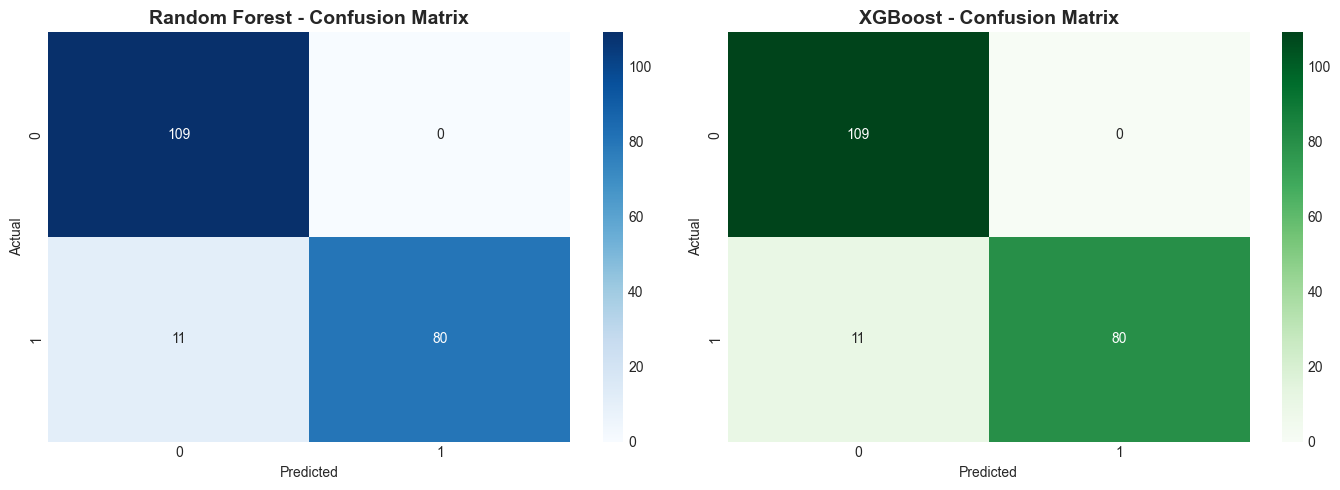


✅ Figure saved: images/03_confusion_matrices.png


In [19]:
# Confusion matrices visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Random Forest confusion matrix
cm_rf = confusion_matrix(y_test, rf_best_predictions)
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=class_names, yticklabels=class_names)
axes[0].set_title('Random Forest - Confusion Matrix', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

# XGBoost confusion matrix
cm_xgb = confusion_matrix(y_test, xgb_best_predictions)
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Greens', ax=axes[1],
            xticklabels=class_names, yticklabels=class_names)
axes[1].set_title(f'{model_name} - Confusion Matrix', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')

plt.tight_layout()
plt.savefig('../images/03_confusion_matrices.png', dpi=150, bbox_inches='tight')
plt.show()
print("\n✅ Figure saved: images/03_confusion_matrices.png")

In [20]:
# Scalability analysis - Performance across data scales
print("\n" + "=" * 60)
print("SCALABILITY ANALYSIS")
print("=" * 60)

# Test performance on different data sizes
data_fractions = [0.1, 0.25, 0.5, 0.75, 1.0]
rf_scale_scores = []
xgb_scale_scores = []
rf_scale_times = []
xgb_scale_times = []

for frac in data_fractions:
    n_samples = int(len(X_train) * frac)
    X_subset = X_train_scaled[:n_samples]
    y_subset = y_train[:n_samples]
    
    # Random Forest
    rf_temp = RandomForestClassifier(**rf_grid_search.best_params_, random_state=42, n_jobs=-1)
    start = time.time()
    rf_temp.fit(X_subset, y_subset)
    rf_scale_times.append(time.time() - start)
    rf_scale_scores.append(accuracy_score(y_test, rf_temp.predict(X_test_scaled)))
    
    # XGBoost
    if XGB_AVAILABLE:
        xgb_temp = xgb.XGBClassifier(**xgb_grid_search.best_params_, random_state=42,
                                     use_label_encoder=False, eval_metric='logloss', n_jobs=-1)
    else:
        xgb_temp = GradientBoostingClassifier(**xgb_grid_search.best_params_, random_state=42)
    start = time.time()
    xgb_temp.fit(X_subset, y_subset)
    xgb_scale_times.append(time.time() - start)
    xgb_scale_scores.append(accuracy_score(y_test, xgb_temp.predict(X_test_scaled)))

print("\n📊 Performance vs Training Size:")
scale_results = pd.DataFrame({
    'Data Fraction': data_fractions,
    'Samples': [int(len(X_train) * f) for f in data_fractions],
    'RF Accuracy': rf_scale_scores,
    'RF Time (s)': rf_scale_times,
    f'{model_name} Accuracy': xgb_scale_scores,
    f'{model_name} Time (s)': xgb_scale_times
})
print(scale_results.to_string(index=False))


SCALABILITY ANALYSIS

📊 Performance vs Training Size:
 Data Fraction  Samples  RF Accuracy  RF Time (s)  XGBoost Accuracy  XGBoost Time (s)
          0.10       80        0.940     0.180919             0.895          0.038429
          0.25      200        0.945     0.174431             0.935          0.051669
          0.50      400        0.945     0.180832             0.925          0.039277
          0.75      600        0.945     0.194371             0.945          0.056352
          1.00      800        0.945     0.221158             0.945          0.051768


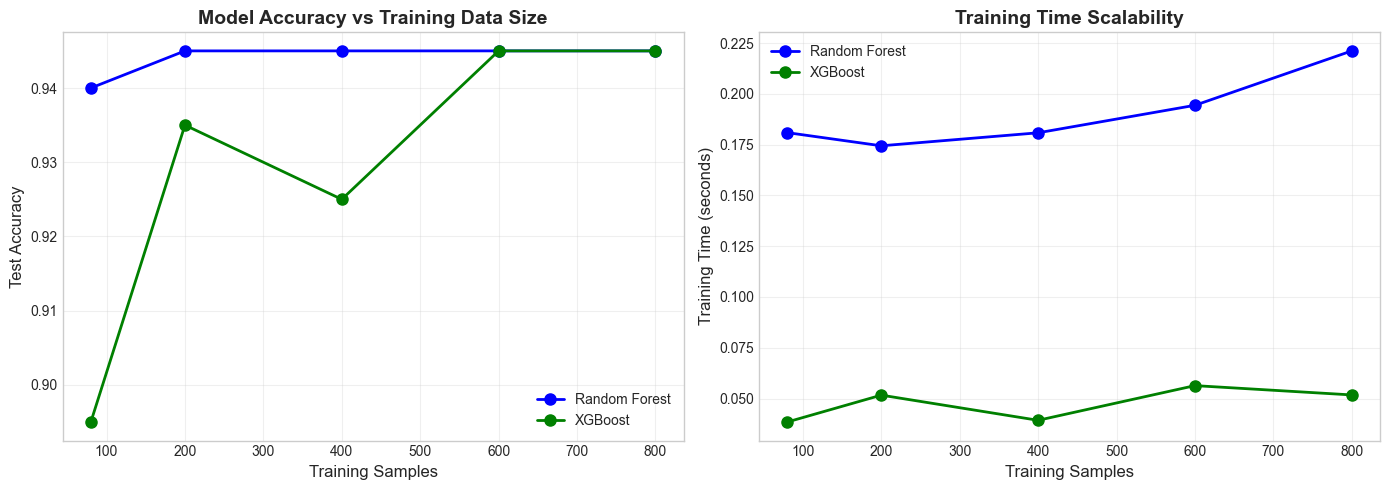


✅ Figure saved: images/03_scalability_analysis.png


In [21]:
# Visualize scalability
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy vs Data Size
ax1 = axes[0]
samples = [int(len(X_train) * f) for f in data_fractions]
ax1.plot(samples, rf_scale_scores, 'bo-', linewidth=2, markersize=8, label='Random Forest')
ax1.plot(samples, xgb_scale_scores, 'go-', linewidth=2, markersize=8, label=model_name)
ax1.set_xlabel('Training Samples', fontsize=12)
ax1.set_ylabel('Test Accuracy', fontsize=12)
ax1.set_title('Model Accuracy vs Training Data Size', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Training Time vs Data Size
ax2 = axes[1]
ax2.plot(samples, rf_scale_times, 'bo-', linewidth=2, markersize=8, label='Random Forest')
ax2.plot(samples, xgb_scale_times, 'go-', linewidth=2, markersize=8, label=model_name)
ax2.set_xlabel('Training Samples', fontsize=12)
ax2.set_ylabel('Training Time (seconds)', fontsize=12)
ax2.set_title('Training Time Scalability', fontsize=14, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('images/03_scalability_analysis.png', dpi=150, bbox_inches='tight')
plt.show()
print("\n✅ Figure saved: images/03_scalability_analysis.png")

In [22]:
# Robustness to noise analysis
print("\n" + "=" * 60)
print("ROBUSTNESS TO NOISE ANALYSIS")
print("=" * 60)

noise_levels = [0, 0.1, 0.2, 0.3, 0.5]
rf_noise_scores = []
xgb_noise_scores = []

for noise in noise_levels:
    # Add Gaussian noise to test data
    X_test_noisy = X_test_scaled + np.random.normal(0, noise, X_test_scaled.shape)
    
    rf_noise_scores.append(accuracy_score(y_test, rf_best.predict(X_test_noisy)))
    xgb_noise_scores.append(accuracy_score(y_test, xgb_best.predict(X_test_noisy)))

print("\n📊 Robustness to Gaussian Noise:")
noise_results = pd.DataFrame({
    'Noise Level (σ)': noise_levels,
    'RF Accuracy': rf_noise_scores,
    f'{model_name} Accuracy': xgb_noise_scores
})
print(noise_results.to_string(index=False))


ROBUSTNESS TO NOISE ANALYSIS

📊 Robustness to Gaussian Noise:
 Noise Level (σ)  RF Accuracy  XGBoost Accuracy
             0.0        0.945             0.945
             0.1        0.920             0.935
             0.2        0.925             0.910
             0.3        0.865             0.900
             0.5        0.825             0.830


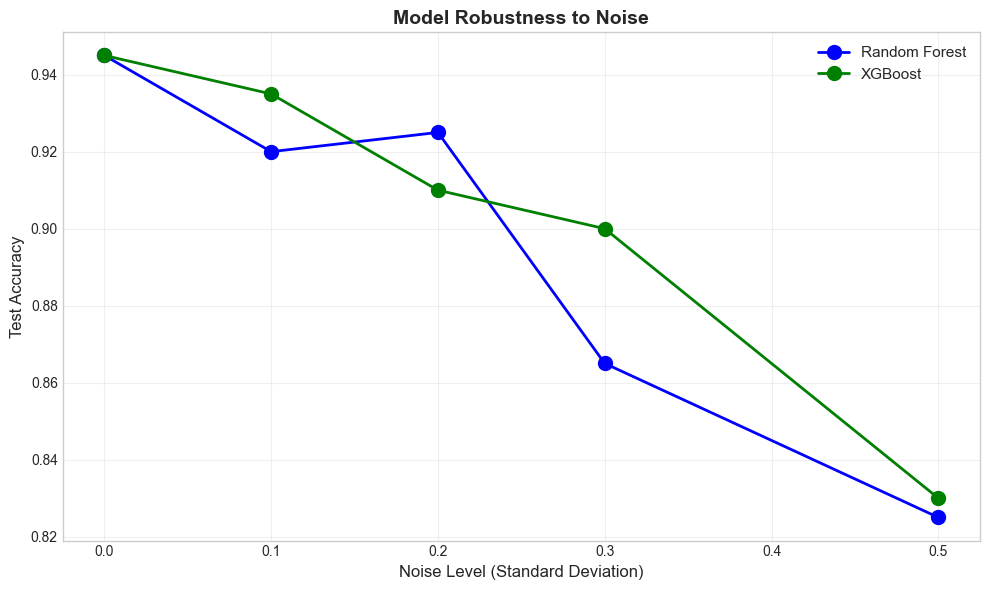


✅ Figure saved: images/03_noise_robustness.png


In [23]:
# Visualize robustness
plt.figure(figsize=(10, 6))
plt.plot(noise_levels, rf_noise_scores, 'bo-', linewidth=2, markersize=10, label='Random Forest')
plt.plot(noise_levels, xgb_noise_scores, 'go-', linewidth=2, markersize=10, label=model_name)
plt.xlabel('Noise Level (Standard Deviation)', fontsize=12)
plt.ylabel('Test Accuracy', fontsize=12)
plt.title('Model Robustness to Noise', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('images/03_noise_robustness.png', dpi=150, bbox_inches='tight')
plt.show()
print("\n✅ Figure saved: images/03_noise_robustness.png")

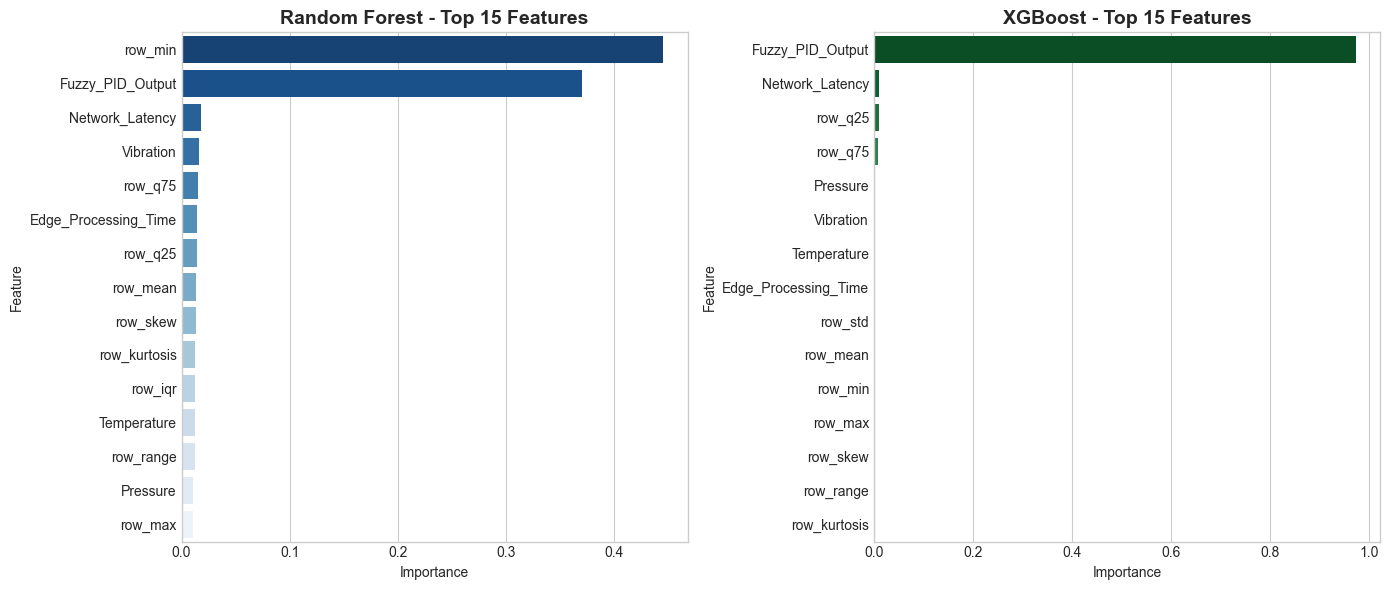


✅ Figure saved: images/03_feature_importance.png


In [24]:
# Feature importance comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Get feature names
feature_names = X.columns.tolist()

# Random Forest feature importance
rf_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': rf_best.feature_importances_
}).sort_values('Importance', ascending=False).head(15)

ax1 = axes[0]
sns.barplot(data=rf_importance, y='Feature', x='Importance', palette='Blues_r', ax=ax1)
ax1.set_title('Random Forest - Top 15 Features', fontsize=14, fontweight='bold')

# XGBoost feature importance
if hasattr(xgb_best, 'feature_importances_'):
    xgb_importance = pd.DataFrame({
        'Feature': feature_names,
        'Importance': xgb_best.feature_importances_
    }).sort_values('Importance', ascending=False).head(15)
    
    ax2 = axes[1]
    sns.barplot(data=xgb_importance, y='Feature', x='Importance', palette='Greens_r', ax=ax2)
    ax2.set_title(f'{model_name} - Top 15 Features', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('images/03_feature_importance.png', dpi=150, bbox_inches='tight')
plt.show()
print("\n✅ Figure saved: images/03_feature_importance.png")

In [25]:
# Generalization limitations discussion
print("\n" + "=" * 60)
print("GENERALIZATION LIMITATIONS")
print("=" * 60)

# Cross-validation for generalization assessment
rf_cv_scores = cross_val_score(rf_best, X_train_scaled, y_train, cv=5, scoring='accuracy')
xgb_cv_scores = cross_val_score(xgb_best, X_train_scaled, y_train, cv=5, scoring='accuracy')

print(f"""
📋 GENERALIZATION ASSESSMENT:

Cross-Validation Results (5-fold):
  • Random Forest: {rf_cv_scores.mean():.4f} (+/- {rf_cv_scores.std()*2:.4f})
  • {model_name}: {xgb_cv_scores.mean():.4f} (+/- {xgb_cv_scores.std()*2:.4f})

Train vs Test Performance Gap:
  • Random Forest: Train={rf_best.score(X_train_scaled, y_train):.4f}, Test={rf_best_accuracy:.4f}
  • {model_name}: Train={xgb_best.score(X_train_scaled, y_train):.4f}, Test={xgb_best_accuracy:.4f}

IDENTIFIED LIMITATIONS:

1. DOMAIN SHIFT:
   - Model trained on IIoT data may not transfer to cloud drift detection
   - Sensor patterns differ from infrastructure configuration patterns

2. TEMPORAL CHANGES:
   - No time-aware validation (using random splits)
   - Real deployments face concept drift over time

3. UNSEEN ATTACK TYPES:
   - Models may fail on novel anomaly types not in training data
   - Requires periodic retraining with new data

4. EDGE DEPLOYMENT:
   - {model_name} model may be too large for edge devices
   - Need model compression or distillation for deployment
""")


GENERALIZATION LIMITATIONS

📋 GENERALIZATION ASSESSMENT:

Cross-Validation Results (5-fold):
  • Random Forest: 0.9337 (+/- 0.0322)
  • XGBoost: 0.9362 (+/- 0.0310)

Train vs Test Performance Gap:
  • Random Forest: Train=0.9600, Test=0.9450
  • XGBoost: Train=0.9363, Test=0.9450

IDENTIFIED LIMITATIONS:

1. DOMAIN SHIFT:
   - Model trained on IIoT data may not transfer to cloud drift detection
   - Sensor patterns differ from infrastructure configuration patterns

2. TEMPORAL CHANGES:
   - No time-aware validation (using random splits)
   - Real deployments face concept drift over time

3. UNSEEN ATTACK TYPES:
   - Models may fail on novel anomaly types not in training data
   - Requires periodic retraining with new data

4. EDGE DEPLOYMENT:
   - XGBoost model may be too large for edge devices
   - Need model compression or distillation for deployment



In [26]:
# Save models and results
import pickle

# Save trained models
with open('data/rf_model.pkl', 'wb') as f:
    pickle.dump(rf_best, f)
with open('data/xgb_model.pkl', 'wb') as f:
    pickle.dump(xgb_best, f)
with open('data/scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

# Save evaluation results
evaluation_results = {
    'rf_results': rf_results,
    'xgb_results': xgb_results,
    'rf_cv_scores': rf_cv_scores.tolist(),
    'xgb_cv_scores': xgb_cv_scores.tolist(),
    'rf_best_params': rf_grid_search.best_params_,
    'xgb_best_params': xgb_grid_search.best_params_
}

with open('data/evaluation_results.json', 'w') as f:
    json.dump(evaluation_results, f, indent=2)

print("\n✅ Models saved to data/ directory")
print("✅ Evaluation results saved to data/evaluation_results.json")


✅ Models saved to data/ directory
✅ Evaluation results saved to data/evaluation_results.json


---

## Summary

### Section D: Model Design
- **Model 1**: Random Forest - Scalable tree-based ensemble with parallel training
- **Model 2**: XGBoost/GradientBoosting - State-of-the-art boosting with regularization
- Both models tuned using GridSearchCV with cross-validation

### Section E: Evaluation
- Metrics: Accuracy, Precision, Recall, F1-Score (weighted)
- Scalability: Tested performance across data sizes
- Robustness: Analyzed degradation under Gaussian noise
- Generalization: Identified domain-specific limitations

**Next Steps**: Project Reflection (Section F) and Entropy Calculations (Section G)